## Sentiment Analysis of IMDB Movie Reviews

**Problem Statement:**

In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models.

**Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stat
import nltk 
from collections import Counter   

from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier 
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier 




**Importing the data**

In [2]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Exploratory data analysis 

In [3]:
df.shape 

(50000, 2)

In [6]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Looks like we have 50K reviews to analyze and our features are object type 

**Target variable distribution**

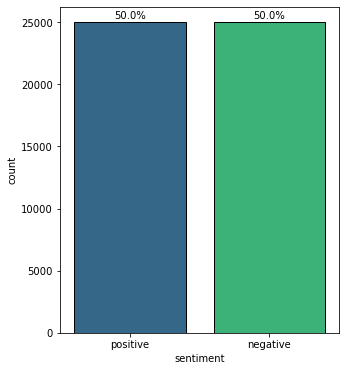

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def value_count_percent(df, feature):
    fig, ax = plt.subplots(figsize=(5, 6))
    top_20 = df[feature].value_counts().nlargest(10)
    ax = sns.countplot(x=feature, data=df, palette='viridis', saturation=0.9, edgecolor="black",
                       order=top_20.index)
    total = float(len(df))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 300, '{:.1f}%'.format((height/total)*100), ha="center")
    plt.show()

value_count_percent(df, "sentiment")


That's good to see our target is balanced 

In [7]:
## function to be used in the future 
def plot_sentiment(df , feature , titlee) : 

    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,4)) 
    sns.kdeplot(df[df['sentiment']=='positive'][feature],ax=ax1 , fill=True)
    ax1.set_title('positive sentiment')
    sns.kdeplot(df[df['sentiment']=='negative'][feature],ax=ax2, fill=True)
    ax2.set_title('negative sentiment')
    fig.suptitle(titlee)
    plt.show()      


**Word and Character counts for each review**

In [8]:
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()) )  
df['character_count'] = df['review'].apply(lambda x: len(x))
df   

,review,sentiment,word_count,character_count
0,One of the other reviewers has mentioned that ...,positive,307,1761
1,A wonderful little production. <br /><br />The...,positive,162,998
2,I thought this was a wonderful way to spend ti...,positive,166,926
3,Basically there's a family where a little boy ...,negative,138,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,1317
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,194,1008
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,112,642
49997,I am a Catholic taught in parochial elementary...,negative,230,1280
49998,I'm going to have to disagree with the previou...,negative,212,1234


Let's see their distributions for each sentiment 

**Distribution of character and words count for each sentiment**

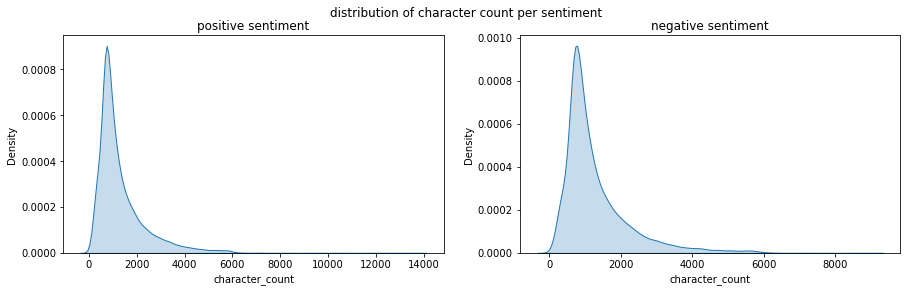

In [9]:
plot_sentiment(df , 'character_count' , 'distribution of character count per sentiment ')

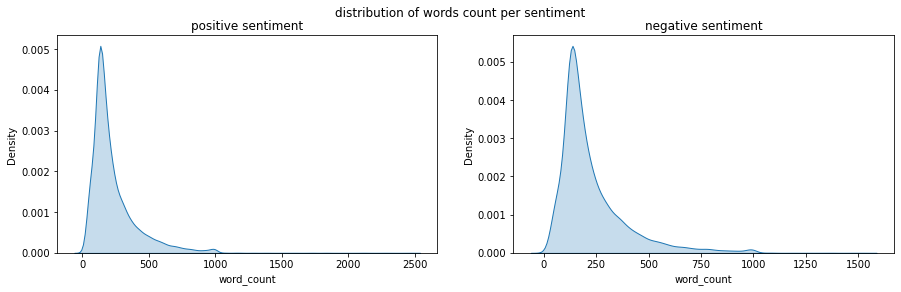

In [10]:
plot_sentiment(df , 'word_count' , 'distribution of words count per sentiment ')

Positive reviews tend to have more words 

**Word clouds overview**

In [11]:
from wordcloud import WordCloud , STOPWORDS 
stopwords = set(STOPWORDS)

def show_wordcloud(data , title):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.title(title ,fontdict={'size': 20, 'color': 'black', 
                                  'verticalalignment': 'bottom'})

    plt.imshow(wordcloud)
    plt.show()   



word cloud for positive reviews 


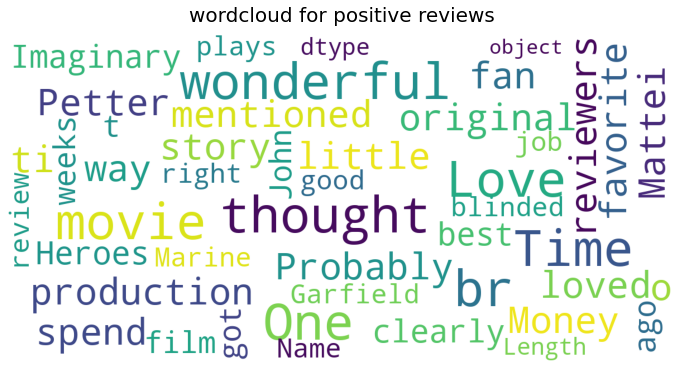

In [12]:
show_wordcloud(df[df['sentiment']=='positive']['review'] , 'wordcloud for positive reviews') 

word cloud for negative reviews 


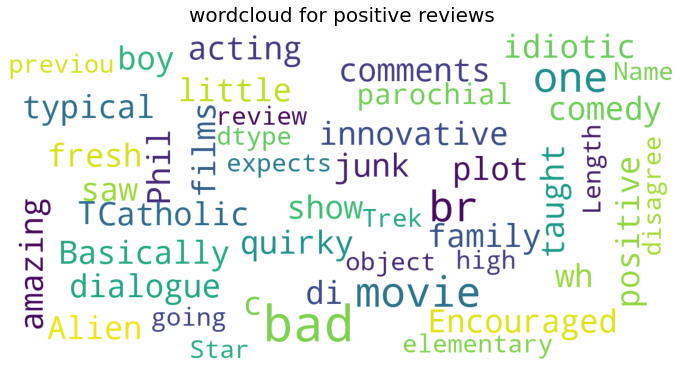

In [13]:
show_wordcloud(df[df['sentiment']=='negative']['review'] , 'wordcloud for positive reviews') 

## Data cleaning 

**cleaning text from regular expressions , punctuation , html syntax , urls**

In [14]:
import re 
import string
from bs4 import BeautifulSoup

def clean_text(text): 
    
    # regular expressions 
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()
    
    # urls 
    text = re.sub(r'http\S+|ftp\S+', '', text)

    #html 
    text = re.sub('<.*?>', '', text)

    # punctuation 
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text 

df['review']=df['review'].apply(lambda z: clean_text(z))
# verification 
df['review'][0]  

'one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with mebr br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordbr br it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awaybr br i would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare fo

**removing stopwords** 

In [15]:
from nltk.tokenize.toktok import ToktokTokenizer 
from nltk.corpus import stopwords   
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')
stop=set(stopwords.words('english'))


def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


df['review']=df['review'].apply(remove_stopwords)


**Removing english abbriviations** 

In [16]:
def remove_abbriviations(text): 
    text = re.sub(r'won\'t', 'will not', text)  
    text = re.sub(r'can\'t', 'cannot', text)  
    text = re.sub(r'i\'m', 'i am', text)   
    text = re.sub(r'ain\'t', 'is not', text)  
    text = re.sub(r'(\w+)\'ll', '\g<1> will', text)  
    text = re.sub(r'(\w+)n\'t', '\g<1> not', text)  
    text = re.sub(r'(\w+)\'ve', '\g<1> have', text)  
    text = re.sub(r'(\w+)\'s', '\g<1> is', text)  
    text = re.sub(r'(\w+)\'re', '\g<1> are', text)  
    text = re.sub(r'(\w+)\'d', '\g<1> would', text)  
    text = re.sub(r'don\'t', 'do not', text)  
    text = re.sub(r'doesn\'t', 'does not', text)  
    text = re.sub(r'didn\'t', 'did not', text)  
    text = re.sub(r'haven\'t', 'have not', text)  
    text = re.sub(r'hasn\'t', 'has not', text)  
    text = re.sub(r'hadn\'t', 'had not', text)  
    text = re.sub(r'wouldn\'t', 'would not', text)  
    text = re.sub(r'shouldn\'t', 'should not', text)  
    text = re.sub(r'mustn\'t', 'must not', text)  
    text = re.sub(r'needn\'t', 'need not', text)  
    text = re.sub(r'it\'s', 'it is', text)  
    text = re.sub(r'they\'re', 'they are', text)  
    text = re.sub(r'we\'re', 'we are', text)  
    text = re.sub(r'you\'re', 'you are', text)  
    text = re.sub(r'he\'s', 'he is', text)  
    text = re.sub(r'she\'s', 'she is', text)  
    text = re.sub(r'we\'ll', 'we will', text)  
    text = re.sub(r'you\'ll', 'you will', text)  
    text = re.sub(r'they\'ll', 'they will', text)      
    return text 

df['review']=df['review'].apply(lambda z: remove_abbriviations(z))

**Seeing the top common words used for each sentiment**

In [17]:
df['Cleaned Reviews Split'] = df['review'].apply(lambda x:str(x).split())

top_pos = Counter([item for sublist in df[ df['sentiment']=='positive']['Cleaned Reviews Split'] for item in sublist])
temp_pos = pd.DataFrame(top_pos.most_common(20))
temp_pos.columns = ['Common_words','count']     

top_neg = Counter([item for sublist in df[ df['sentiment']=='negative']['Cleaned Reviews Split'] for item in sublist])
temp_neg = pd.DataFrame(top_neg.most_common(20))
temp_neg.columns = ['Common_words','count']     


<AxesSubplot:xlabel='Common_words', ylabel='count'>

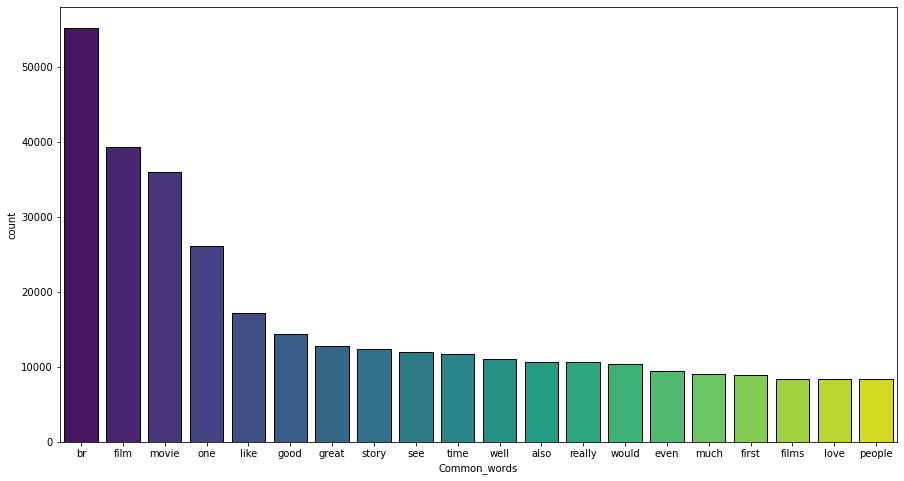

In [18]:
plt.figure(figsize=(15, 8))
sns.barplot(x='Common_words' , y = 'count', data=temp_pos, palette='viridis', saturation=0.9, edgecolor="black")

<AxesSubplot:xlabel='Common_words', ylabel='count'>

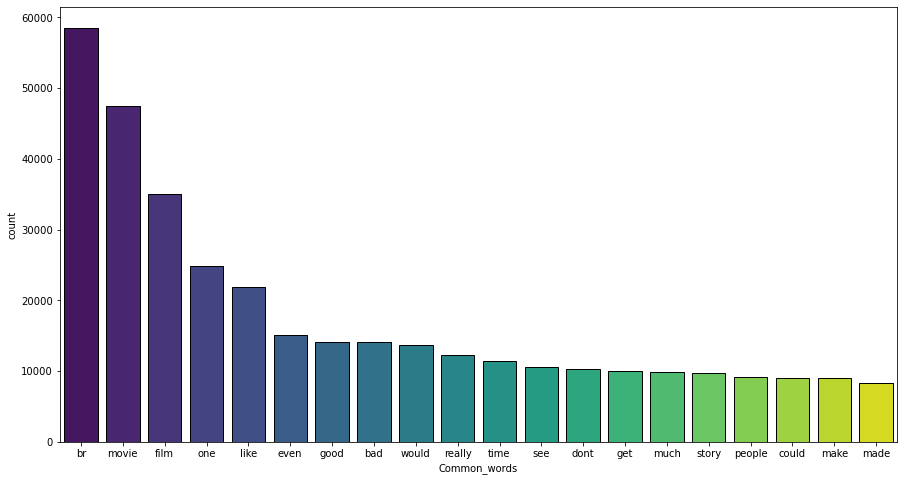

In [19]:
plt.figure(figsize=(15, 8))
sns.barplot(x='Common_words' , y = 'count', data=temp_neg, palette='viridis', saturation=0.9, edgecolor="black")

## Modeling 

**Vectorization : TFIDF**

We will use TFIDF vectorization strategy

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

#encode our target 

le = LabelEncoder() 
df['sentiment'] = le.fit_transform(df['sentiment'])

# create our X and Y 
X , Y = df['review'].tolist() , df['sentiment'].tolist() 
TfidfVec =TfidfVectorizer(stop_words='english',ngram_range=(1,1))
X_tfidf  = TfidfVec.fit_transform(X) 



In [4]:
X_tfidf.shape

(50000, 180101)

Our X inputs are perfect now and ready to be put to the model 

**Splitting our data** 

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, 
                                                    Y,
                                                    test_size=0.3)

**Defining our models**

In [5]:
names = [
    "Logistic Regression",
    "XGBoost",
    "lgbm"
]

models = [
    LogisticRegression(max_iter = 1000),
    XGBClassifier(),
    LGBMClassifier() , 
] 

**Model evaluation**

In [8]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    for model in models  : 
        print('starting ...')
        print(f"Model: {model.__class__.__name__}")
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))
        print('finished ! ')

    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [9]:
score(X_train, y_train, X_test, y_test, names = names, models = models)  

starting ...
finished ! 
starting ...
finished ! 
starting ...
finished ! 


,Classifier,Training accuracy,Validation accuracy
0,Logistic Regression,0.937714,0.889800
2,lgbm,0.900257,0.855467
1,XGBoost,0.926914,0.850533


Our models did perform well , there is some overfitting as we can see our validation score is less than our training . Let's see a full classification report 

In [12]:
from sklearn.metrics import classification_report , roc_auc_score

for model in models : 
    print(f"Model: {model.__class__.__name__}")
    y_pred = model.predict(X_test)
    print(classification_report(y_test , y_pred))

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7544
           1       0.88      0.90      0.89      7456

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

Model: XGBClassifier
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      7544
           1       0.84      0.87      0.85      7456

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000

Model: LGBMClassifier
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      7544
           1       0.85      0.87      0.86      7456

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weigh

Looks great , let's tune our xgboost model for better results 

In [6]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier 

model = XGBClassifier()

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [ 8 , 12 , 15 ],
    'n_estimators': [100, 500, 1000],

} 

# Perform grid search
grid_search = GridSearchCV(model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max

**best parameters for xgboost**

In [7]:
grid_search.best_params_ 

{'max_depth': 8, 'n_estimators': 1000}

## Final model prediction

In [16]:
from sklearn import metrics
# confusion matrix function 
def conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16):
    class_names = [0, 1] 
    tick_marks_y = [0.5, 1.5]   
    tick_marks_x = [0.5, 1.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(2), range(2))
    plt.figure(figsize = figsize)
    sns.set(font_scale = font_scale) 
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": annot_kws_size}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()   

**Training for our best params**

In [18]:
final_model = XGBClassifier( max_depth =  8, n_estimators =  1000)
final_model.fit(X_train, y_train)  

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

**Confusion Matrix**

Test accuracy    0.8784
 


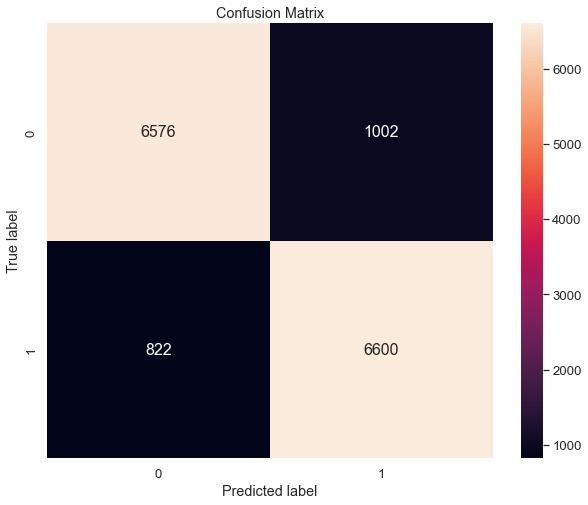

In [17]:
from sklearn.metrics import accuracy_score

y_test_pred = final_model.predict(X_test)
score_test = accuracy_score(y_test, y_test_pred)
print(pd.Series({"Test accuracy": score_test}).to_string())
print(" ")
conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16) # Confusion matrix
print(" ") 